In [1]:
#Check if dataset loads

import csv
import os
import numpy as np
import cv2
DATASET_PATH = "../../data/udacity_sim_data"

def load_dataset(file_path):
    '''
    Loads dataset in memory
    '''
    dataset = []
    with open(file_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            try:
                dataset.append({'center':line[0], 'left':line[1], 'right':line[2], 'steering':float(line[3]), 
                            'throttle':float(line[4]), 'brake':float(line[5]), 'speed':float(line[6])})
            except:
                continue
    return dataset

dataset = load_dataset(os.path.join(DATASET_PATH, "driving_log.csv"))
print("Loaded {} samples from file {}".format(len(dataset),DATASET_PATH))

Loaded 45999 samples from file ../../data/udacity_sim_data



Exploring the dataset ...


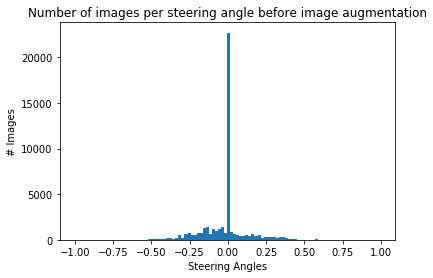

Exploring the dataset complete.


In [2]:
# Plot data distribution

import matplotlib.pyplot as plt
 
print("\nExploring the dataset ...")
 
# It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
def plot_steering_histogram(steerings, title, num_bins=100):
    plt.hist(steerings, num_bins)
    plt.title(title)
    plt.xlabel('Steering Angles')
    plt.ylabel('# Images')
    plt.show()
 
# It plots the histogram of an arrray of associative arrays of angles: [{'steering':0.1}, {'steering':0.2}, ..., {'steering':-0.1}]
def plot_dataset_histogram(dataset, title, num_bins=100):
    steerings = []
    for item in dataset:
        steerings.append( float(item['steering']) )
    plot_steering_histogram(steerings, title, num_bins)
 
# Plot the histogram of steering angles before the image augmentation
plot_dataset_histogram(dataset, 'Number of images per steering angle before image augmentation', num_bins=100)
print("Exploring the dataset complete.")

In [ ]:
# Extract features from CNN

from keras.models import load_model, Model
from keras.models import model_from_json
from tqdm import tqdm

MODEL_PATH = "../../data/weights/steer_only/model.json"

def model_layer_output(model, layer_name, image_file):
    test_model = Model(input=model.input, output=model.get_layer(layer_name).output)

    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_array = np.asarray(image)
    image_array = image_array[None, :, :, :]

    flat_feature = test_model.predict(image_array, batch_size=50)

    return flat_feature

with open(MODEL_PATH, 'r') as jfile:
    model = model_from_json(jfile.read())

model.compile("adam", "mse")
weights_file = MODEL_PATH.replace('json', 'h5')
model.load_weights(weights_file)


steering_angle_set = []
input_feature_set = []
for instant in tqdm(dataset, total=len(dataset)):
    steering_angle_set.append(instant["steering"])
    image_file = os.path.join(DATASET_PATH, instant["center"].strip())
    feature = model_layer_output(model, 'FC2', image_file)
    input_feature_set.append(feature)

steering_angle_set = np.array(steering_angle_set)
input_feature_set = np.array(input_feature_set)

print(steering_angle_set.shape)
print(input_feature_set.shape)

In [ ]:
np.save("features.npy", input_feature_set)
np.save("steering.npy", steering_angle_set)

In [11]:
input_feature_set = np.load("features.npy")
steering_angle_set = np.load("steering.npy")

from sklearn.model_selection import train_test_split

seq_len = 30
BATCH_SIZE = 512

input_feature_set = input_feature_set.reshape(-1, 64)
steering_angle_set = steering_angle_set.reshape(-1, 1)

X_train, X_test = train_test_split(input_feature_set, test_size=0.15)
Y_train, Y_test = train_test_split(steering_angle_set, test_size=0.15)

print("train set has {} elements".format(Y_train.shape))
print("test set has {} elements".format(Y_test.shape))

def data_generator(steering_angle_set, input_feature_set, seq_len):
    batch_seq_features = np.zeros((BATCH_SIZE, seq_len, input_feature_set.shape[1]))
    batch_seq_steering_angles = np.zeros((BATCH_SIZE, seq_len))
    #batch_seq_steering_angles = np.zeros((BATCH_SIZE))
    
    while 1:
        for i in range(BATCH_SIZE):
            while 1:
                index = np.random.randint(len(steering_angle_set))
                if index + seq_len <= len(steering_angle_set):
                    seq_features = input_feature_set[index: index + seq_len]
                    seq_steering_angles = steering_angle_set[index: index + seq_len]
                    break
                else:
                    continue
            batch_seq_features[i] = seq_features
            batch_seq_steering_angles[i] = seq_steering_angles.reshape([1, seq_len])
            #batch_seq_steering_angles[i] = seq_steering_angles

        # for ru
        yield batch_seq_features, batch_seq_steering_angles[:, :, np.newaxis]#[:, np.newaxis]


train set has (39099, 1) elements
test set has (6900, 1) elements


In [21]:
# Define RNN model

from keras.models import Sequential, Model
from keras.layers.recurrent import GRU, LSTM
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam, RMSprop

print("\nBuilding and compiling the model ...")

model = Sequential()
# Layer 1 RNN
model.add(GRU(32, input_shape=(None, 64), return_sequences=True, init='glorot_uniform', inner_init='glorot_uniform', 
              activation='elu', inner_activation='hard_sigmoid', name="GRU1"))
model.add(Dropout(0.5))
# Layer 2 RNN
# model.add(GRU(16, return_sequences=True, init='glorot_uniform', inner_init='glorot_uniform', 
#               activation='elu', inner_activation='hard_sigmoid', name="GRU2"))
# model.add(Dropout(0.2))
# Block - fully connected
model.add(Dense(1, activation='linear', name='output'))
model.summary()

adam = Adam(lr=0.0001)
#rmsprop = RMSprop(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=adam)


Building and compiling the model ...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
GRU1 (GRU)                       (None, None, 32)      9312        gru_input_6[0][0]                
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, None, 32)      0           GRU1[0][0]                       
____________________________________________________________________________________________________
output (Dense)                   (None, None, 1)       33          dropout_7[0][0]                  
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
____________________________________________________________________________________________________


In [ ]:
import keras
from keras.callbacks import Callback
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import math

class LifeCycleCallBack(keras.callbacks.Callback):
    
    def on_epoch_begin(self, epoch, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):
        pass

    def on_batch_begin(self, batch, logs={}):
        pass
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
    def on_train_begin(self, logs={}):
        print('Beginning training')
        self.losses = []
        
    def on_train_end(self, logs={}):
        print('Ending Training')


NUM_EPOCHS = 2000
        
lifecycle_callback = LifeCycleCallBack()

tensorboard = keras.callbacks.TensorBoard(log_dir='../../data/logs/steer_rnn/', histogram_freq=1, 
                                          write_graph=True, write_images=True)

checkpoint = keras.callbacks.ModelCheckpoint("../../data/weights/steer_rnn/model.h5", monitor='val_loss', verbose=0, 
                                             save_best_only=True, save_weights_only=True, mode='auto', period=1)

train_generator = data_generator(Y_train, X_train, seq_len)
valid_generator = data_generator(Y_test, X_test, seq_len)

samples_per_epoch = math.ceil((len(Y_train) - seq_len)/(BATCH_SIZE))*BATCH_SIZE
nb_val_samples = math.ceil((len(Y_test) - seq_len)/BATCH_SIZE)*BATCH_SIZE

history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              samples_per_epoch=samples_per_epoch,
                              nb_val_samples=nb_val_samples,
                              nb_epoch=NUM_EPOCHS, verbose=1, 
                              callbacks=[lifecycle_callback, tensorboard, checkpoint])

print("\nTraining the model ended.")

print("\nSaving Model...")

model_json = model.to_json()
with open("../../data/weights/steer_rnn/model.json", "w") as json_file:
    json_file.write(model_json)

#model.save_weights("model.h5")
print("Model Saved.")

Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are cr

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Inst

39168/39168 [==============================] - 2s - loss: 0.0236 - val_loss: 0.0214
Epoch 38/2000
39168/39168 [==============================] - 2s - loss: 0.0240 - val_loss: 0.0230
Epoch 39/2000
39168/39168 [==============================] - 2s - loss: 0.0240 - val_loss: 0.0224
Epoch 40/2000
39168/39168 [==============================] - 2s - loss: 0.0235 - val_loss: 0.0216
Epoch 41/2000
39168/39168 [==============================] - 2s - loss: 0.0234 - val_loss: 0.0222
Epoch 42/2000
39168/39168 [==============================] - 2s - loss: 0.0237 - val_loss: 0.0213
Epoch 43/2000
39168/39168 [==============================] - 2s - loss: 0.0237 - val_loss: 0.0217
Epoch 44/2000
39168/39168 [==============================] - 2s - loss: 0.0235 - val_loss: 0.0224
Epoch 45/2000
39168/39168 [==============================] - 2s - loss: 0.0234 - val_loss: 0.0219
Epoch 46/2000
39168/39168 [==============================] - 2s - loss: 0.0238 - val_loss: 0.0214
Epoch 47/2000
39168/39168 [=======

In [ ]:
# Plot train and valid loss curve

# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
